<a href="https://colab.research.google.com/github/javadch/covid19/blob/master/Covid19_Cases_Europe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This document is a try to give an insight into the Corona related data of Europe.

The data is obtained from [ECDC](https://www.ecdc.europa.eu) which is free, open, and contains worldwide cumulative counts for new confirmed, deaths, and recovered cases. It may have missing values, especially in the recovered cases, which I did not try to improve.
In this study, China has been used as a baseline to be able to compare German data and be able to make sense of the situation.

Information about the author can be found [here](https://www.tib.eu/en/research-development/data-science-digital-libraries/staff/javad-chamanara/).

In [0]:
import datetime as dt
import pandas as pd
import requests
import io
import math
import matplotlib.pyplot as plt

Obtaining the Corona related data as of today (UTC) from the ECDC.

In [67]:
nowUtc = dt.datetime.utcnow()
url_pattern = 'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-YYYY-MM-DD.xlsx'
# It is possible that ECDC has not yet uploaded the today's data.
# In this case, I fallback to yesterday's dataset
try:
  data_url = url_pattern.replace('YYYY', f'{nowUtc.year:04d}').replace('MM', f'{nowUtc.month:02d}').replace('DD', f'{nowUtc.day:02d}')
  #print(data_url) 
  data = pd.read_excel(data_url, index_col=0) 
except: # fallback to yesterday
  nowUtc = nowUtc- dt.timedelta(days=1)
  data_url = url_pattern.replace('YYYY', f'{nowUtc.year:04d}').replace('MM', f'{nowUtc.month:02d}').replace('DD', f'{nowUtc.day:02d}')
  #print(data_url) 
  data = pd.read_excel(data_url, index_col=0) 
print(data.tail(5))

            Day  Month  Year  Cases  Deaths Countries and territories GeoId
DateRep                                                                    
2020-03-19   19      3  2020      2       0                    Zambia    ZM
2020-03-24   24      3  2020      0       1                  Zimbabwe    ZW
2020-03-23   23      3  2020      0       0                  Zimbabwe    ZW
2020-03-22   22      3  2020      1       0                  Zimbabwe    ZW
2020-03-21   21      3  2020      1       0                  Zimbabwe    ZW


Obtaining the list fo countries with their area and population from this [GitHub repository](https://github.com/javadch/covid19/blob/master/data/Coutries.xlsx).

In [0]:
countries_url = 'https://github.com/javadch/covid19/raw/master/data/Countries.xlsx'
countries = pd.read_excel(countries_url, index_col=0)
selected_coutries_geoid = ['DE', 'UK', 'IT', 'FR'] # the two letter country code of those designated to be shown on the charts
selected_countries = countries[countries.index.isin(selected_coutries_geoid)].sort_values(by=['Name'], ascending=True)
total_popluation = selected_countries['Population'].sum()
total_area = selected_countries['AreaKm2'].sum()
#print(selected_countries.head(5))

In the following diagrams, I will draw a series of three side by side charts. At each row, the charts show the cumulative confirmed and death cases for all the selecte countries, as well as single chart that shows the average cumulative death for all.

In [0]:
# get the portion of data relevant to selected countries
selected_data  = data[data['GeoId'].isin(selected_countries.index)]
# the resulting data frame should have date, avg, and total
aggregated = pd.DataFrame(index=pd.date_range(start='2019-12-29', end=nowUtc, freq='D'), columns=['Total', 'Average'])
aggregated = aggregated.fillna(0) # with 0s rather than NaNs
# calculating the total death of all the selected countries per day
for index, data_row in selected_data.iterrows():
  if(index in aggregated.index):
    aggregated.loc[index, 'Total'] = aggregated.loc[index, 'Total'] + data_row['Deaths']
# average the death data per day
aggregated['Average'] = aggregated['Total']/len(selected_countries.index)
#print(aggregated.tail(5))

Diagram 1 shows the number of confirmed, deaths in the selected countries as well as the total death in all the selected countries.

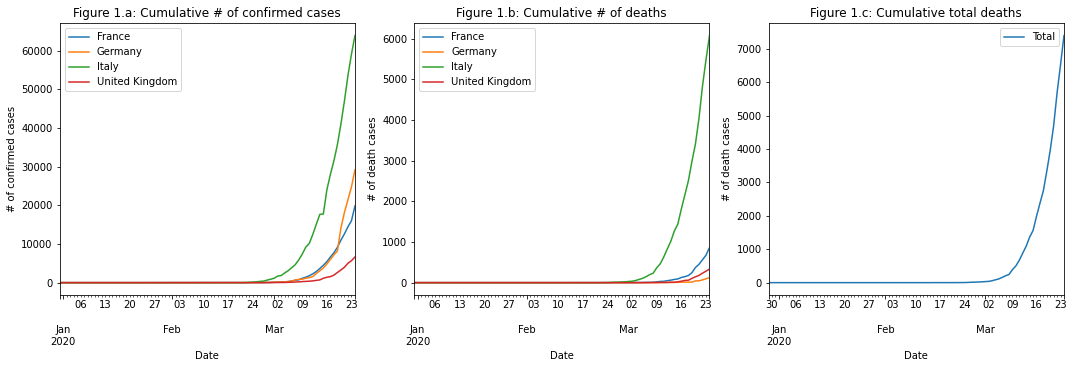

In [70]:
fig1, axs1 = plt.subplots(1,3, figsize=(18, 5))

for index, row in selected_countries.iterrows():
  #print(row['Name'], row['Population'], index)
  data[(data['GeoId'] == index)].sort_values(by=['DateRep'], ascending=True)['Cases'].cumsum().plot(ax=axs1[0], label = row['Name'])
axs1[0].set_xlabel('Date')
axs1[0].set_ylabel('# of confirmed cases')
axs1[0].set_title("Figure 1.a: Cumulative # of confirmed cases")
axs1[0].legend()

for index, row in selected_countries.iterrows():
  data[(data['GeoId'] == index)].sort_values(by=['DateRep'], ascending=True)['Deaths'].cumsum().plot(ax=axs1[1], label = row['Name'])
axs1[1].set_xlabel('Date')
axs1[1].set_ylabel('# of death cases')
axs1[1].set_title("Figure 1.b: Cumulative # of deaths")
axs1[1].legend()

aggregated['Total'].cumsum().plot(ax=axs1[2], label = 'Total')
axs1[2].set_xlabel('Date')
axs1[2].set_ylabel('# of death cases')
axs1[2].set_title("Figure 1.c: Cumulative total deaths")
axs1[2].legend()

plt.show()

Diagram 2 shows the number of confirmed and deaths in the selected countries per countries' population as well as the total death in all the selected countries per total population.

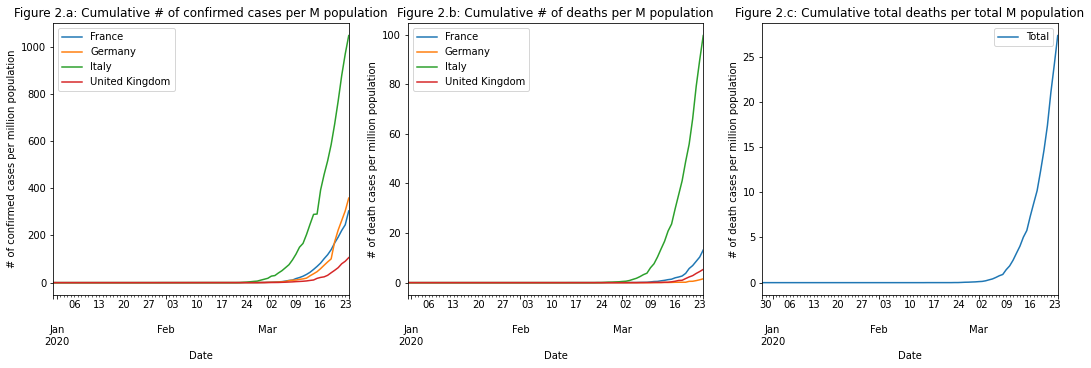

In [71]:
fig2, axs2 = plt.subplots(1,3, figsize=(18, 5))

for index, row in selected_countries.iterrows():
  (data[(data['GeoId'] == index)].sort_values(by=['DateRep'], ascending=True)['Cases'].cumsum()*1000000/row['Population']).plot(ax=axs2[0], label = row['Name'])
axs2[0].set_xlabel('Date')
axs2[0].set_ylabel('# of confirmed cases per million population')
axs2[0].set_title("Figure 2.a: Cumulative # of confirmed cases per M population")
axs2[0].legend()

for index, row in selected_countries.iterrows():
  (data[(data['GeoId'] == index)].sort_values(by=['DateRep'], ascending=True)['Deaths'].cumsum()*1000000/row['Population']).plot(ax=axs2[1], label = row['Name'])
axs2[1].set_xlabel('Date')
axs2[1].set_ylabel('# of death cases per million population')
axs2[1].set_title("Figure 2.b: Cumulative # of deaths per M population")
axs2[1].legend()

(aggregated['Total'].cumsum()*1000000/total_popluation).plot(ax=axs2[2], label = 'Total')
axs2[2].set_xlabel('Date')
axs2[2].set_ylabel('# of death cases per million population')
axs2[2].set_title("Figure 2.c: Cumulative total deaths per total M population")
axs2[2].legend()

plt.show()

Diagram 3 shows the number of confirmed and deaths in the selected countries per countries' unit of area $km^2$ as well as the total death in all the selected countries per $km^2$.

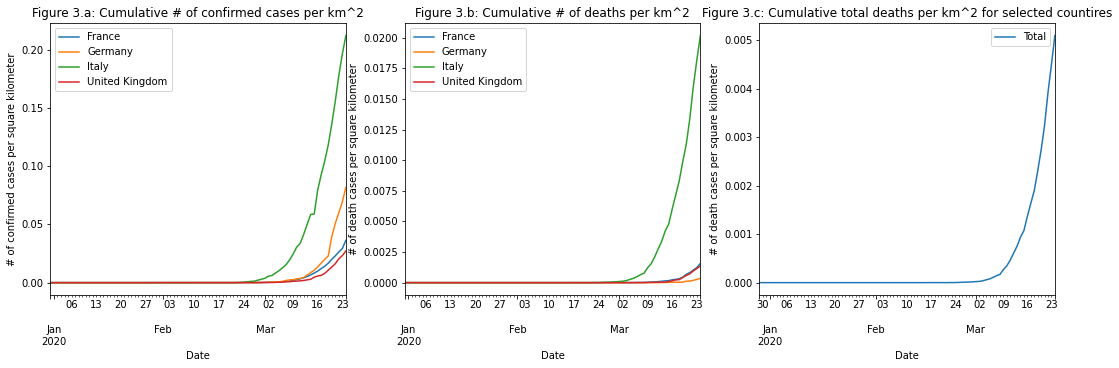

In [72]:
fig3, axs3 = plt.subplots(1,3, figsize=(18, 5))

for index, row in selected_countries.iterrows():
  (data[(data['GeoId'] == index)].sort_values(by=['DateRep'], ascending=True)['Cases'].cumsum()/row['AreaKm2']).plot(ax=axs3[0], label = row['Name'])
axs3[0].set_xlabel('Date')
axs3[0].set_ylabel('# of confirmed cases per square kilometer')
axs3[0].set_title("Figure 3.a: Cumulative # of confirmed cases per km^2")
axs3[0].legend()

for index, row in selected_countries.iterrows():
  (data[(data['GeoId'] == index)].sort_values(by=['DateRep'], ascending=True)['Deaths'].cumsum()/row['AreaKm2']).plot(ax=axs3[1], label = row['Name'])
axs3[1].set_xlabel('Date')
axs3[1].set_ylabel('# of death cases per square kilometer')
axs3[1].set_title("Figure 3.b: Cumulative # of deaths per km^2")
axs3[1].legend()

(aggregated['Total'].cumsum()/total_area).plot(ax=axs3[2], label = 'Total')
axs3[2].set_xlabel('Date')
axs3[2].set_ylabel('# of death cases per square kilometer')
axs3[2].set_title("Figure 3.c: Cumulative total deaths per km^2 for selected countires")
axs3[2].legend()

plt.show()